In [10]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn import svm
from sklearn.metrics import *
import xgboost as xgb
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (25,10)
import seaborn as sns
from ipynb.fs.full.Performance_Utilities import calculate_optimal_threshold, print_metrics
from utils.create_features_utils import *
from sklearn.base import clone
import os

In [2]:
df = pd.read_csv('data/wimbledon_matches_with_feature.csv')
raw_tennis_file = "data/mens/combined_raw_data.csv"
round_16_file = "data/wimbledon_2019.csv"

In [3]:
round_16 = pd.read_csv(round_16_file) # Round of 16 and on from Wimbledon 2019
raw_tennis = pd.read_csv(raw_tennis_file) # Raw tennis file

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (27,33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
features_list = [
 'diff_rank',
 'diff_match_win_percent',
 'diff_games_win_percent',
 'diff_5_set_match_win_percent',
 'diff_close_sets_percent',
 'diff_match_win_percent_grass',
 'diff_games_win_percent_grass',
 'diff_5_set_match_win_percent_grass',
 'diff_close_sets_percent_grass',
 'diff_match_win_percent_52',
 'diff_games_win_percent_52',
 'diff_5_set_match_win_percent_52',
 'diff_close_sets_percent_52',
 'diff_match_win_percent_grass_60',
 'diff_games_win_percent_grass_60',
 'diff_5_set_match_win_percent_grass_60',
 'diff_close_sets_percent_grass_60',
 'diff_match_win_percent_hh',
 'diff_games_win_percent_hh',
 'diff_match_win_percent_grass_hh',
 'diff_games_win_percent_grass_hh']

In [5]:
df = df.dropna()

df['diff_rank'] = df['player_0_rank'] - df['player_1_rank']

In [6]:
# Train-test split
y = df.outcome
X = df[features_list]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, shuffle=True, test_size=0.20)

In [7]:
# Final to predict on
round_16['Date'] = '2019/07/07'
round_16['Surface'] = 'Grass'
round_16['diff_rank'] = round_16['player_0_rank'] - round_16['player_1_rank']

wimby_2019 = create_features(round_16, raw_tennis) # Round 16 and on Wimby 2019
X_wimby_2019 = wimby_2019[features_list]

Creating Player Career Stats All Surface
Creating Player Career Stats on Grass/Clay/Hard
Creating Player Career Stats All Surface Last 52 Weeks
Creating Player Career Stats on Grass/Clay/Hard Last 60 Weeks
Creating Player Head to Head Career Stats All Surface
Creating Player Head to Head Career Stats On Grass
Creating Difference Variables


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:1143: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:1143: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:1143: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https

KeyError: "None of [Int64Index([ 12,  37,  68,  79,  82,  94,  95,  97,  99, 106, 122, 128, 130,\n            147, 151, 157, 172, 183, 188, 192, 195, 198],\n           dtype='int64')] are in the [index]"

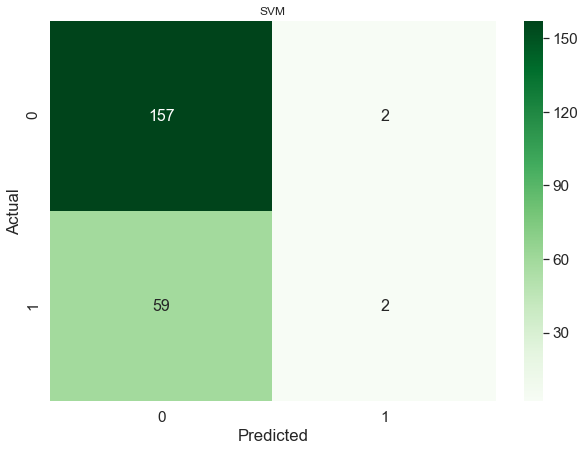

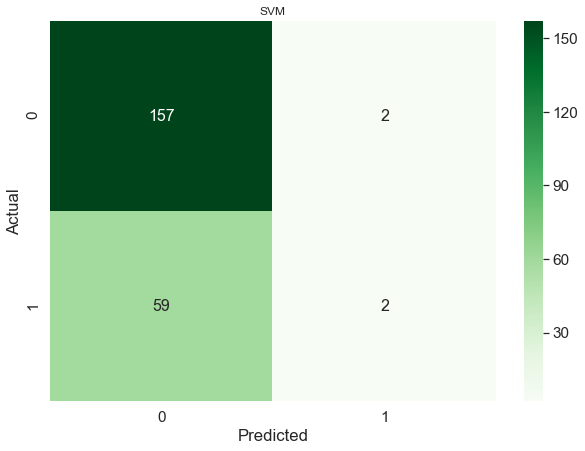

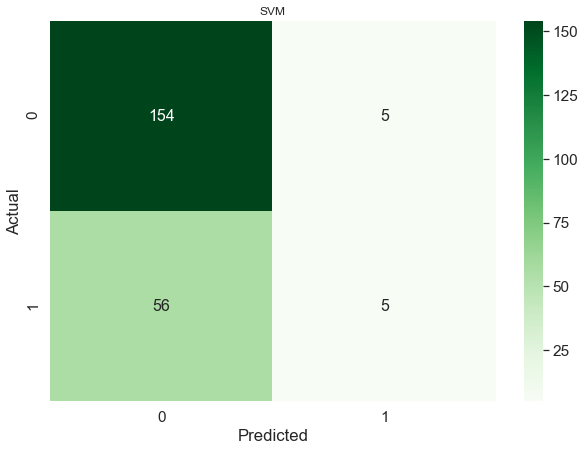

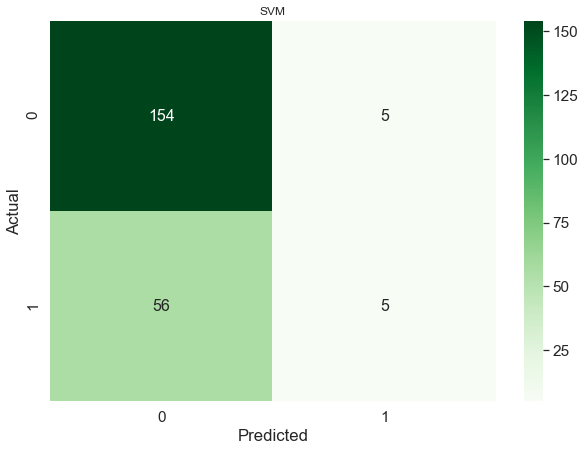

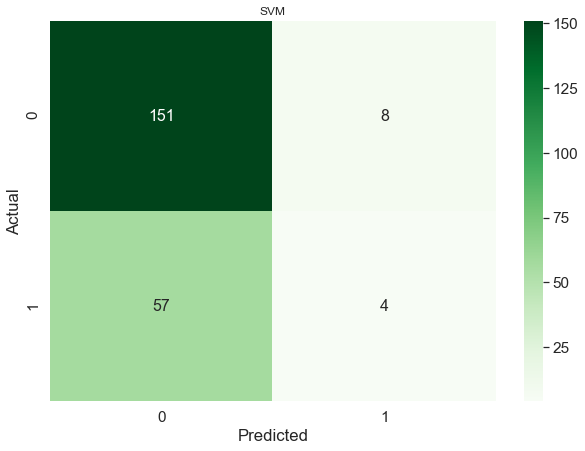

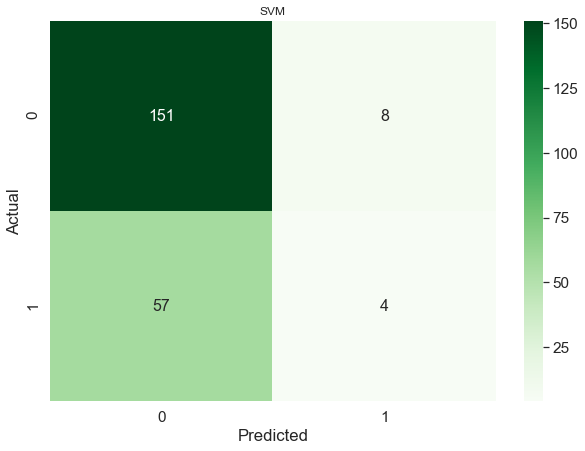

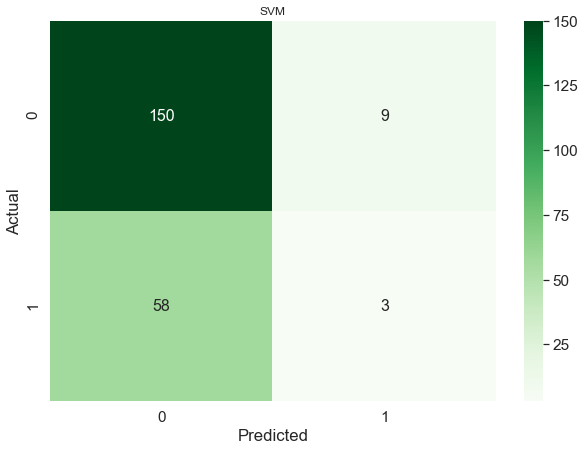

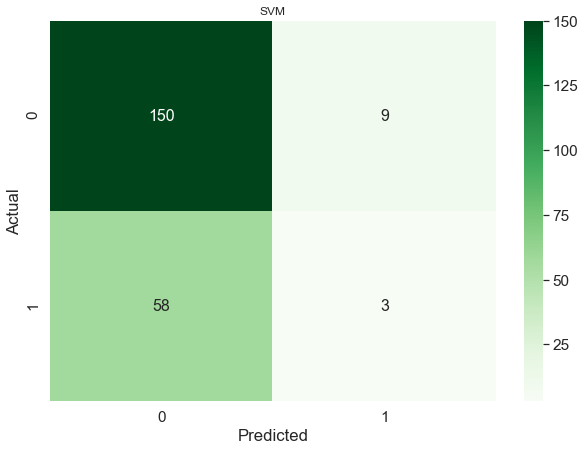

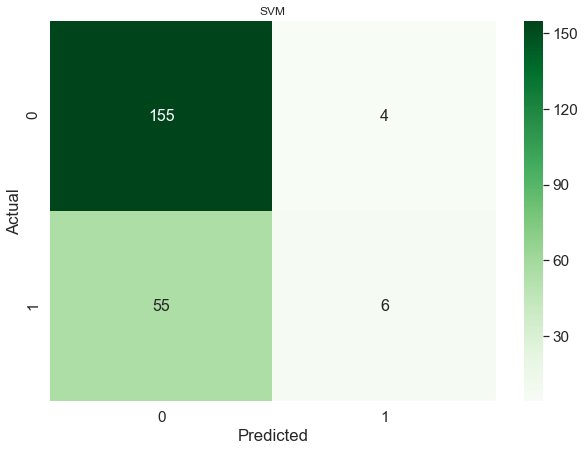

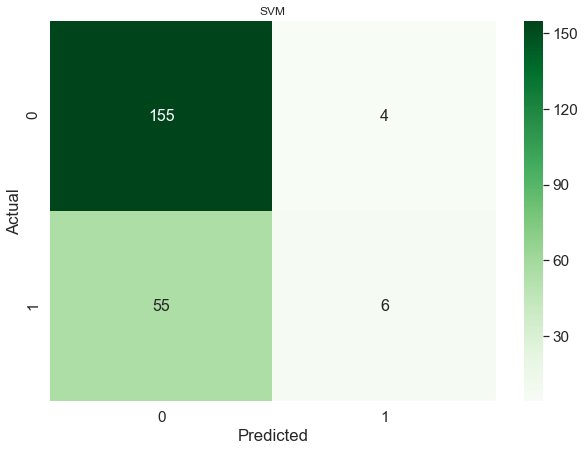

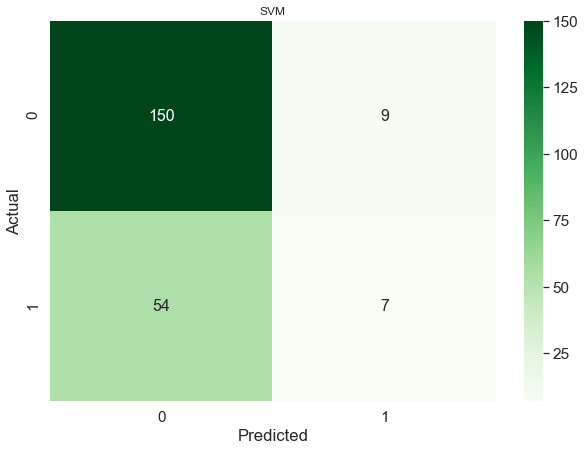

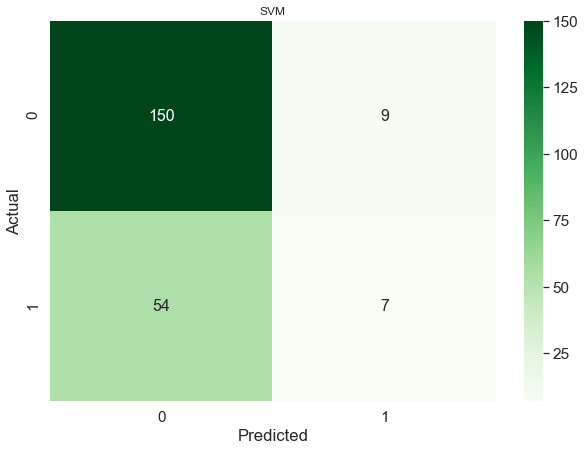

In [8]:
# SVM
C = [1, 1.5, 2, 3, 4]
gamma = [.05, .1, .2, .5]
params = [(x, y) for x in C for y in gamma]
auc_ls = []
f1_ls = []

for i in params:
    svm_model = svm.SVC(C = i[0], gamma = i[1], probability=True, kernel = "rbf", random_state = 345)
    svm_model.fit(X_train, y_train)
    auc = print_metrics(X_test, y_test, svm_model, "SVM")[2]
    f1 = print_metrics(X_test, y_test, svm_model, "SVM")[3]
    auc_ls.append(auc)
    f1_ls.append(f1)

6
6


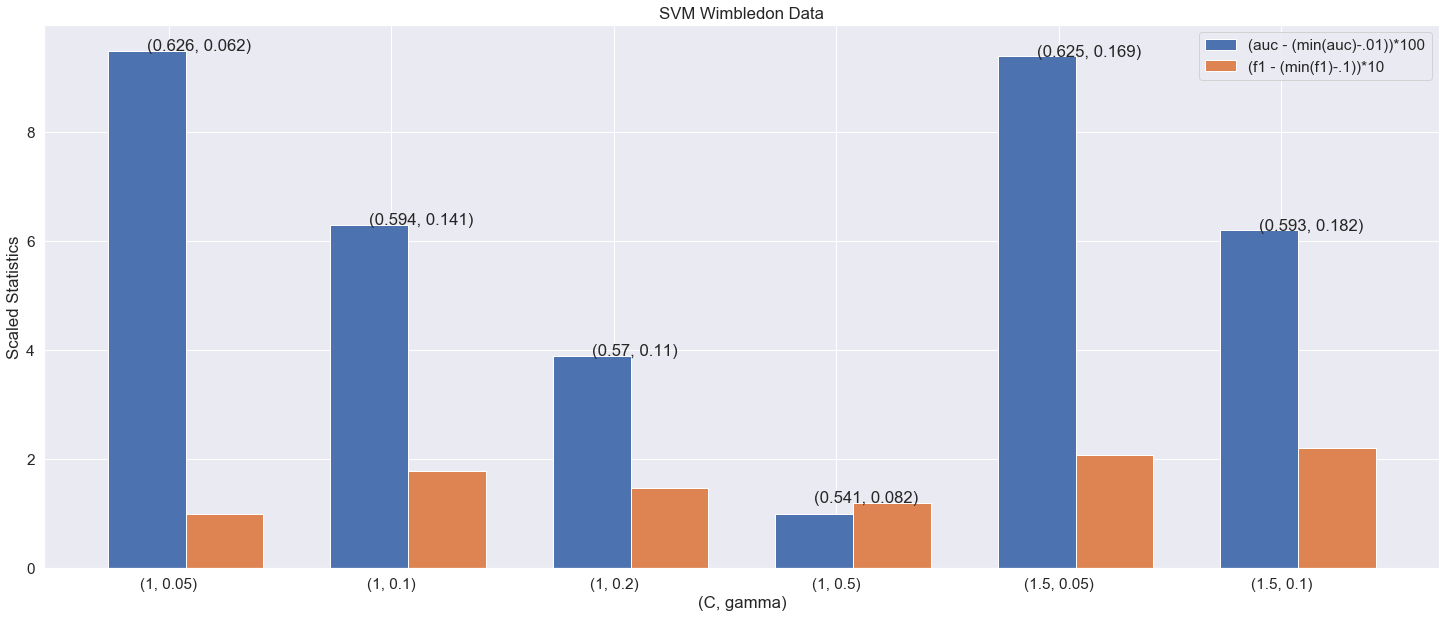

In [11]:
# Scale for plotting
scale_auc_ls = (auc_ls - (min(auc_ls)-.01))*100
print(len(scale_auc_ls))
scale_f1_ls = (f1_ls - (min(f1_ls)-.1))*10
print(len(scale_f1_ls))

# Plot
#n_combos = len(params)
index = np.arange(len(scale_auc_ls))
axes = plt.gca()
bar_width = .35

aucs = plt.bar(index, scale_auc_ls, bar_width, label = "(auc - (min(auc)-.01))*100")
f1s = plt.bar(index+bar_width, scale_f1_ls, bar_width, label = "(f1 - (min(f1)-.1))*10")

plt.xticks(index+.1, params)
for i, v in enumerate(scale_auc_ls):
    plt.text(i, max(scale_auc_ls[i], scale_f1_ls[i]), str((auc_ls[i], f1_ls[i])))

plt.xlabel("(C, gamma)")
plt.ylabel("Scaled Statistics")
plt.title("SVM Wimbledon Data")
plt.legend()